# Multislice Simulations

The multislice approximation is at the core of all simulations of electreon microscopy images.

## Planewave multislice simulation

Using what we learned in the previous tutorials, it is straightforward to perform a multislice calculation with planewaves. Here we use the atomic model, we exported in an earlier tutorials.

In [17]:
from abtem.potentials import Potential
from abtem.waves import PlaneWaves
from ase.io import read
from ase.visualize import view

srtio3 = read('srtio3_110.cif')

wave = PlaneWaves(sampling=.1, energy=300e3)

potential = Potential(srtio3)

exit_wave = wave.multislice(potential, show_progress=False)

We can plot the exit wave function using the `plot_image` function.

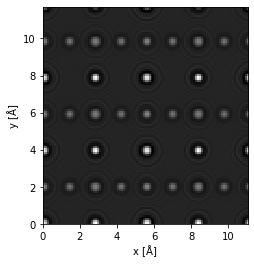

In [18]:
from abtem.plot import plot_image
plot_image(exit_wave)

In [5]:
from abtem.waves import Waves
exit_wave.write('srtio3_exit_wave.npz')
exit_wave = Waves.read('srtio3_exit_wave.npz')

## Compatible grids

You may have noted that the extent of the wave function was not given in the above, nor was the sampling of the potential. Since the potential have an extent, from the cell of the atoms, and the sampling is defined for the wave function, there is enough information to infer the grid, before starting the multislice propagation.

The following will result in a runtime error because the sampling of the of the wave function and the potential is different.

Only wave function builders

## Probe wave function multislice simulation